In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pickle
import warnings
warnings.filterwarnings('ignore')
import re

In [2]:
congresses = [str(i) for i in range(97, 115)]
congresses = ['0' + x if len(x) == 2 else x for x in congresses ]
congresses

['097',
 '098',
 '099',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114']

In [3]:
mapping = {'treati': 'treaty', 'salari': 'salary', 'judici': 'judiciary', 'poverti': 'poverty', 'navi': 'navy', 'militari': 'military', 'regulatori': 'regulatory', 'duti': 'duty', 'treasuri': 'treasury', 'recoveri': 'recovery', 'armi': 'army', 'freedeliveri': 'freedelivery', 'busi': 'business', 'privaci': 'privacy', 'bankruptci:': 'bankruptcy', 'safeti': 'safety', 'bureaucraci': 'bureaucracy', 'selfsuffici': 'selfsufficy', 'alreadi': 'already', 'bankruptci': 'bankruptcy', 'monetari': 'monetary', 'simplifi': 'simplify', 'germani': 'germany', 'subsidiari': 'subsidiary', 'secondari': 'secondary', 'machineri': 'machinery', 'mandatori': 'mandatory', 'migratori': 'migratory', 'fisheri': 'fishery', 'equiti': 'equity', 'postsecondari': 'postsecondary', 'discriminatori': 'discriminatory', 'penalti': 'penalty', 'forestri': 'forestry', 'difficulti': 'difficulty', 'elementari': 'elementary', 'pariti': 'parity', 'secretari': 'secretary', 'slurri': 'slurry', 'dairi': 'dairy', 'duli': 'duly', 'daili': 'daily', 'antipoverti': 'antipoverty', 'liberti': 'liberty', 'laboratori': 'laboratory', 'judiciari': 'judiciary', 'wealthi': 'wealthy', 'entiti': 'entity', 'faculti': 'faculty', 'conspiraci': 'conspiracy', 'surgeri': 'surgery', 'countri': 'country', 'realiti': 'reality', 'everi': 'every', 'smallbusi': 'smallbusy', 'energi': 'energy', 'discretionari': 'discretionary', 'ssi': 'ssy', 'societi': 'society', 'communiti': 'community', 'compensatori': 'compensatory', 'prioriti': 'priority', 'properti': 'property', 'liquefi': 'liquefy', 'democraci': 'democracy', 'deputi': 'deputy', 'revolutionari': 'revolutionary', 'beneficiari': 'beneficiary', 'qualiti': 'quality', 'jewri': 'jewry', 'enemi': 'enemy', 'compulsori': 'compulsory',\
 'economi':'econom',
 'polici':'policy',
 'famili':'family',
 'lobbi':'lobby',
 'bodi':'body',
 'victori':'victory',
 'theori':'theor',
    'countri':'country',
    'healthi':'health',
    'needi':'need',
    'primari':'primary',
    'studi':'stud',
    'territori':'territor',
    'voluntari':'voluntar',
    'deliveri':'delivery',
    'scrutini':'scrutiny',
    'necessari':'necessary',
    'philosophi':'philosoph',
    'juri':'jury',
    'speedi':'speedy',
    'basi':'basic',
    'treasuri':'treasury',
    
}

In [4]:
keyword_file = './data/hein-daily/keywords.txt'
topic_keywords = {}
one_grams = set()
with open(keyword_file) as f:
    lines = f.readlines()[1:]
    for line in lines:
        topic, word = line.split('|')
        word = word.strip()
        if word in mapping:
            word = mapping[word]
                        
        topic_keywords[word] = topic.strip()
        one_grams.add(word)
    
len(topic_keywords),len(one_grams) 

(282, 282)

In [5]:
bigram_file = './data/hein-daily/topic_phrases.txt'
bi_grams = set()
with open(bigram_file) as f:
    lines = f.readlines()[1:]
    for line in lines:
        topic, word = line.split('|')
        
        b1, b2 = word.split()
        if b1.strip() in mapping:
            b1 = mapping[b1.strip()]
        if b2.strip() in mapping:
            b2 = mapping[b2.strip()]
        
        
        topic_keywords[word.strip()] = topic.strip()
        topic_keywords[b1] = topic.strip()
        topic_keywords[b2] = topic.strip()
        bi_grams.add(word.strip())
        
len(bi_grams)

6929

In [6]:
topic_keywords

{'alcohol': 'government',
 'antisaloon': 'alcohol',
 'distil': 'alcohol',
 'liquor': 'alcohol',
 'malt': 'alcohol',
 'saloon': 'alcohol',
 'spirit': 'alcohol',
 'balanc': 'trade',
 'budget': 'tax',
 'debt': 'labor',
 'defici': 'budget',
 'expenditur': 'tax',
 'expens': 'tax',
 'revenu': 'trade',
 'spend': 'tax',
 'treasury': 'money',
 'agricultur': 'trade',
 'banker': 'business',
 'bankruptcy': 'justice',
 'business': 'trade',
 'canal': 'foreign',
 'capit': 'tax',
 'chief execut': 'business',
 'coal': 'labor',
 'commerc': 'trade',
 'commod': 'business',
 'compani': 'trade',
 'credit': 'tax',
 'electr': 'business',
 'enterpri': 'business',
 'farm': 'labor',
 'financ': 'health',
 'fishermen': 'business',
 'gas': 'tax',
 'industri': 'trade',
 'leather': 'business',
 'loan': 'labor',
 'manufactur': 'trade',
 'mine': 'money',
 'oil': 'tax',
 'owner': 'crime',
 'patent': 'justice',
 'petroleum': 'business',
 'plant': 'environment',
 'potato': 'business',
 'privat': 'labor',
 'profit': 'tax',

In [7]:
ts_df = pd.read_csv('./data/SWOW_prediction/eval/time_series/nyt_ts_df.csv')

ts_df = ts_df.groupby(['words','year','property'])[['outputs_z','count']].mean().reset_index()
ts_df = ts_df.loc[ts_df['count'] >= 50]

In [8]:
nyt_words = set(ts_df.words.unique())

In [9]:
final_words = set()
for word in nyt_words:
    if word in one_grams:
        final_words.add(word)
        continue
   

In [10]:
congress_list_rows = []


In [11]:
for congress in congresses:
    d = pickle.load(open(f'./data/hein-daily/word_counts_{congress}.pkl','rb'))
    word_count = d['word_counts']
    for w in word_count :
        w_clean = re.sub('[^A-Za-z0-9]+', '', w)
        if w_clean not in final_words:
            continue
        for year in word_count[w]:
            congress_list_rows.append({
                'words':w_clean,
                'year':year,
                'congress':congress,
                'speech_count': word_count[w][year],
                
        
            })

In [12]:
len(congress_list_rows)

22355

In [13]:
congress_df = pd.DataFrame(congress_list_rows)

In [14]:
congress_df['words'] = congress_df['words'].apply(lambda x : re.sub('[^A-Za-z0-9]+', '', x))
congress_df=congress_df.groupby(['words','year','congress']).speech_count.sum().reset_index()

In [15]:
year_total = congress_df.groupby(['year','congress']).speech_count.sum().to_dict()
congress_df['speech_count_norm'] = congress_df.apply(lambda x : x.speech_count/year_total[(x.year,x.congress)],axis=1)
congress_df

,words,year,congress,speech_count,speech_count_norm
0,afghanistan,1981,097,640,0.002513
1,afghanistan,1982,097,575,0.002241
2,afghanistan,1983,098,593,0.002215
3,afghanistan,1984,098,426,0.001736
4,afghanistan,1985,099,703,0.002406
...,...,...,...,...,...
6366,worker,2013,112,26,0.013279
6367,worker,2013,113,2198,0.011509
6368,worker,2014,113,1780,0.010912
6369,worker,2015,114,1938,0.010288


In [16]:
words = congress_df.words.unique()
print(len(words))

174


In [17]:
len(congress_df)

6371

In [18]:
congress_df = congress_df.loc[(congress_df.words.isin(final_words)) & (congress_df.words.isin(nyt_words))]

In [19]:
congress_df.sample(1)

,words,year,congress,speech_count,speech_count_norm
4010,owner,1991,102,919,0.003019


In [20]:
joint_df = ts_df.set_index(['words','year']).\
join(congress_df.set_index(['words','year'])).reset_index()
joint_df = joint_df.loc[~pd.isna(joint_df.congress)]

In [21]:
joint_df.sample()

,words,year,property,outputs_z,count,congress,speech_count,speech_count_norm
512231,treaty,1989,previous_link,1.351123,2162.0,101,174.0,0.000697


In [22]:
rel_df = joint_df.loc[joint_df.property == 'previous_link'].drop('property',axis = 1)
pol_df = joint_df.loc[joint_df.property == 'polarity'].drop('property',axis = 1)

In [23]:
final_df = rel_df.set_index(['words','year','count','congress','speech_count','speech_count_norm']).\
join(pol_df.set_index(['words','year','count','congress','speech_count','speech_count_norm']),lsuffix = '_relevance',
    rsuffix = '_polarity').reset_index()

In [24]:
final_df.sample()

,words,year,count,congress,speech_count,speech_count_norm,outputs_z_relevance,outputs_z_polarity
1098,equal,2006,1925.0,109,928.0,0.004026,1.299129,1.164346


In [25]:
new_df = final_df.copy(deep = True)
new_df['year'] = new_df['year'] + 1


In [26]:
rate_df = final_df.set_index(['words','year']).\
join(new_df.set_index(['words','year']),lsuffix = '_2',rsuffix = '_1').reset_index()
rate_df['previous_year'] = rate_df['year'] - 1

In [27]:
rate_df.sample()

,words,year,count_2,congress_2,speech_count_2,speech_count_norm_2,outputs_z_relevance_2,outputs_z_polarity_2,count_1,congress_1,speech_count_1,speech_count_norm_1,outputs_z_relevance_1,outputs_z_polarity_1,previous_year
531,care,1990,8834.0,101,5835.0,0.020897,2.47861,2.237353,10220.0,101,6672.0,0.02672,2.467186,2.286088,1989


In [28]:
rate_df['congress_change'] = np.log(rate_df['speech_count_norm_2']) - np.log(rate_df['speech_count_norm_1'])
rate_df['polarity_change']= rate_df['outputs_z_polarity_2'] - rate_df['outputs_z_polarity_1']
rate_df['relevance_change'] = rate_df['outputs_z_relevance_2'] - rate_df['outputs_z_relevance_1']
rate_df['year'] = rate_df['year'] - rate_df['year'].min() 

In [29]:
rate_df.sample(2)

,words,year,count_2,congress_2,speech_count_2,speech_count_norm_2,outputs_z_relevance_2,outputs_z_polarity_2,count_1,congress_1,speech_count_1,speech_count_norm_1,outputs_z_relevance_1,outputs_z_polarity_1,previous_year,congress_change,polarity_change,relevance_change
1694,lake,0,4252.0,100,742.0,0.002545,-1.378753,0.085100,NaN,NaN,NaN,NaN,NaN,NaN,1986,NaN,NaN,NaN
2861,spend,18,5180.0,109,2165.0,0.007557,-0.229812,0.015299,4941.0,108,1869.0,0.007853,-0.256888,0.019302,2004,-0.038504,-0.004003,0.027077


In [30]:
rate_df['congress_1']= rate_df['congress_1'].apply(lambda c :str(c))
rate_df['congress_2']= rate_df['congress_2'].apply(lambda c :str(c))

In [31]:
rate_df['speech_count_1_log'] = np.log(rate_df['speech_count_norm_1'])
rate_df['speech_count_2_log'] = np.log(rate_df['speech_count_norm_2'])

In [32]:
mean_value = rate_df['speech_count_1_log'].mean()
std_value =  rate_df['speech_count_1_log'].std()
rate_df['speech_count_1_log_norm'] = (rate_df['speech_count_1_log'] - mean_value) / std_value

In [33]:
based_model = smf.ols(formula = 'congress_change ~ year + speech_count_1_log+ C(words)',
                data = rate_df).fit()
base_r2 = based_model.rsquared
print(based_model.summary())

                            OLS Regression Results                            
Dep. Variable:        congress_change   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     5.321
Date:                Sat, 11 Jan 2025   Prob (F-statistic):           5.93e-86
Time:                        10:32:15   Log-Likelihood:                -1069.1
No. Observations:                3257   AIC:                             2486.
Df Residuals:                    3083   BIC:                             3546.
Df Model:                         173                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2

In [34]:
model = smf.ols(formula = 'congress_change ~ speech_count_1_log + relevance_change + polarity_change + C(words)',
                data = rate_df).fit()
base_r2 = model.rsquared
rate_df['prediction'] = model.predict(rate_df)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        congress_change   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     5.754
Date:                Sat, 11 Jan 2025   Prob (F-statistic):           1.34e-96
Time:                        10:32:25   Log-Likelihood:                -1036.5
No. Observations:                3257   AIC:                             2423.
Df Residuals:                    3082   BIC:                             3488.
Df Model:                         174                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2

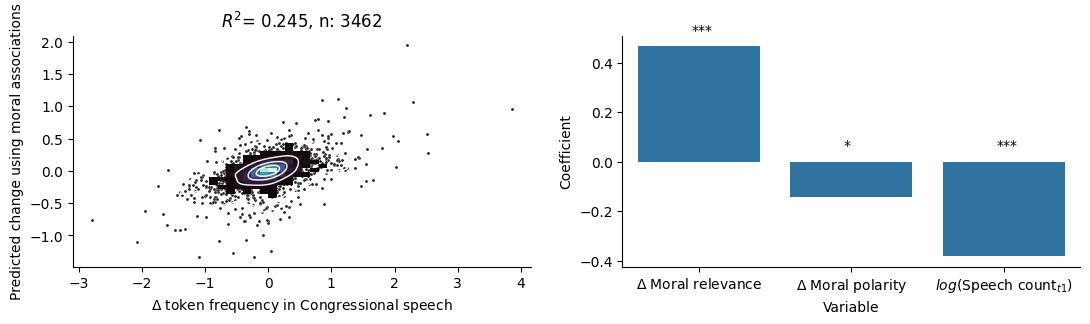

In [35]:
fig, axes = plt.subplots(1,2, figsize = (13, 3))
ax =axes[0]
sns.scatterplot(data = rate_df,x='congress_change', y='prediction',  s=5, color=".15",ax= ax)
sns.histplot(data = rate_df,x='congress_change', y='prediction', bins=50, pthresh=.1, cmap="mako",ax = ax)
sns.kdeplot(data = rate_df,x='congress_change', y='prediction',levels=5, color="w", linewidths=1,ax = ax)
ax.set_title(rf'$R^2$= {round(model.rsquared, 3)}, n: {len(rate_df)}')
ax.set_xlabel(rf'$\Delta$ token frequency in Congressional speech')
ax.set_ylabel('Predicted change using moral associations')
ax = axes[1]
coef_df = pd.DataFrame({
    'Variable': [r'$\Delta$ Moral relevance',r'$\Delta$ Moral polarity', r'$log$(Speech count$_{t1}$)'],
    'Coefficient': [model.params.relevance_change,model.params.polarity_change, model.params.speech_count_1_log],
    'Pvalue': [model.pvalues.relevance_change,model.pvalues.polarity_change, model.pvalues.speech_count_1_log],
      'CI Lower': [model.conf_int().loc['relevance_change'][0], model.conf_int().loc['polarity_change'][0], model.conf_int().loc['speech_count_1_log'][0]],
    'CI Upper': [model.conf_int().loc['relevance_change'][1], model.conf_int().loc['polarity_change'][1], model.conf_int().loc['speech_count_1_log'][1]]
})
# Calculate the error bars

coef_df['yerr_lower'] = coef_df['Coefficient'] - coef_df['CI Lower']
coef_df['yerr_upper'] = coef_df['CI Upper'] - coef_df['Coefficient']
coef_df['yerr'] = list(zip(coef_df['yerr_lower'], coef_df['yerr_upper']))

# Plot with error bars
sns.barplot(data=coef_df, x='Variable', y='Coefficient', ax=ax,)


# sns.barplot(data = coef_df,x ='Variable', y = 'Coefficient',ax = ax)
for i, row in coef_df.iterrows():
    pval = row['Pvalue']
    x = i - 0.05
    y = max(0.05, row['Coefficient'] + 0.05)
    astrik = ''
    if  0.01 <pval < 0.05:
        astrik = '*'
    elif pval < 0.01 and pval > 0.001:
        astrik = '**'
    else:
        astrik = '***'
    ax.text(x = x, y = y, s = astrik)

sns.despine()
# plt.savefig('notebooks/figs/nyt_congress_speech_prediction.pdf',dpi = 400, bbox_inches = 'tight')